In [ ]:
import os
import rasterio
import geopandas as gpd
import pandas as pd
import time
import numpy as np


In [ ]:

starttime = time.time()
#reading in GEDI points
gedi_df = gpd.read_file('../data/GEDI_data/clipped_gedi.gpkg', driver='GPKG', index = True)
endtime = time.time()
print(f"Reading in the GEDI shapefile took {endtime - starttime} seconds")
# print(gedi_df.head())
#reading in ICESat2 shapefile
icesat_df = gpd.read_file('../data/GEDI_data/clipped_icesat.shp', driver='ESRI Shapefile', index = True)
# print(icesat_df.head())


Reading in the GEDI shapefile took 2577.54851436615 seconds


NameError: name 'time' is not defined

In [1]:
# Get unique values in GeoTIFF column
unique_geotiffs = icesat_df['GeoTIFF'].unique()

# Specify the file location of the TIFF files
tif_folder = 'reprojected_icesat_to_gedi_crs'

bins = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]
min = np.full((len(bins)+1), np.inf)
max = np.zeros(len(bins)+1)
num_points = np.zeros(len(bins)+1)
mean_helper = np.zeros(len(bins)+1)
std_helper = np.zeros(len(bins)+1)

# Iterate over unique GeoTIFF values
for geotiff in unique_geotiffs:
    # Create an empty list to store the data
    list = []
    # Construct the file path
    tif_file = os.path.join(tif_folder, geotiff[:-4] + '_reprojected.tif')
    
    # Load the TIFF file using rasterio
    with rasterio.open(tif_file) as icesat_tif:
        print(icesat_tif)

        filtered_df =  gpd.read_file('../data/GEDI_data/clipped_gedi.gpkg', driver='GPKG', index = True, bbox=icesat_tif.bounds)
        print(filtered_df.head())
        # Iterate through the "gedi shot number" values
        for _, point in filtered_df.iterrows():
            # Extract the GEDI shot number
            gedi_shot_number = point['shot_numbe']
            # Extract the latitude, longitude, and agbd values
            lat = point['lat_lowest']
            lon = point['lon_lowest']
            agbd_gedi = point['agbd']
            row, col = icesat_tif.index(lon, lat)
            agbd_icesat = icesat_tif.read(1)[row, col]

            if agbd_icesat != -9999:
                index = np.digitize(agbd_gedi, bins)
                difference = agbd_gedi - agbd_icesat
                num_points[index] += 1
                if difference < min[index]:
                    min[index] = difference
                if difference > max[index]:
                    max[index] = difference
                mean_helper[index] += difference
                std_helper[index] += difference**2
                

                # Create a dictionary with the data
                data = {
                    'Gedi Shot Number': gedi_shot_number,
                    'ICESat Tile': geotiff,
                    'ICESat AGBD': agbd_icesat,
                    'GEDI AGBD': agbd_gedi,
                    'Difference': agbd_gedi - agbd_icesat,
                    'Latitude': lat,
                    'Longitude': lon
                }

                # Append the data to the list
                list.append(data)
    #save the dataframe to a csv file
    df = pd.DataFrame(list) 
    df.to_csv(f'comparisons_bins/gedi_icesat_agbd_comparison_{geotiff}.csv', index=False)
    print("Dataframe saved to csv file")
     



NameError: name 'icesat_df' is not defined

In [3]:
bins = [45,46,47,48,49,50,51,52]
min = np.full((len(bins)+1), np.inf)
max = np.zeros(len(bins)+1)
num_points = np.zeros(len(bins)+1)
mean_helper = np.zeros(len(bins)+1)
std_helper = np.zeros(len(bins)+1)

folder = 'comparisons_bins'
i = 0
# Iterate over unique GeoTIFF values
for file in os.listdir(folder):
 
     filtered_df =  pd.read_csv(os.path.join(folder, file))
    # Iterate through the "gedi shot number" values
    for _, point in filtered_df.iterrows():
        i += 1
        # Extract the GEDI shot number
        gedi_shot_number = point['Gedi Shot Number']
        lat = point['Latitude']
        lon = point['Longitude']
        agbd_gedi = point['GEDI AGBD']
        agbd_icesat = point['ICESat AGBD']

        if (0 <= agbd_icesat <= 500 and 0 <= agbd_gedi <= 500 and not np.isnan(agbd_gedi) and not np.isnan(agbd_icesat)):
            index = np.digitize(lat, bins)
            difference = agbd_gedi - agbd_icesat
            num_points[index] += 1
            if difference < min[index]:
                min[index] = difference
            if difference > max[index]:
                max[index] = difference
            mean_helper[index] += difference
            std_helper[index] += difference**2
    print(file)


mean = mean_helper / num_points
std = np.sqrt(std_helper / num_points - mean**2)
print("done")


gedi_icesat_agbd_comparison_boreal_agb_202302061675662992_3787.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675664614_4323.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675664841_4431.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675665322_4358.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675665893_3594.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675666045_3500.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675666457_3691.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675666514_3410.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675666627_3501.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675666888_3877.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675666898_3595.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675666959_3779.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675667165_3960.tif.csv
gedi_icesat_agbd_comparison_boreal_agb_202302061675667209_3688.tif.csv
gedi_i

num_points [6.890000e+02 9.420600e+04 4.133840e+05 4.956810e+05 8.128300e+05
 1.362889e+06 1.930317e+06 5.069652e+06 5.783660e+05]
min [-157.418735  -215.7320236 -207.54155   -202.7205077 -170.75794
 -234.34376   -217.390065  -233.46785   -187.393565 ]
max [415.770566  476.2824394 474.303572  489.006771  489.841307  486.915231
 490.2251415 490.897158  485.544233 ]
mean [56.66749703 89.57724946 49.94324481 48.49905078 55.57157892 47.02132665
 41.46628954 27.84259979 28.39734271]
std [69.82165417 79.38945349 74.83119395 71.28685354 68.58301906 69.20864043
 67.38950178 65.17814601 65.86832574]
9
9


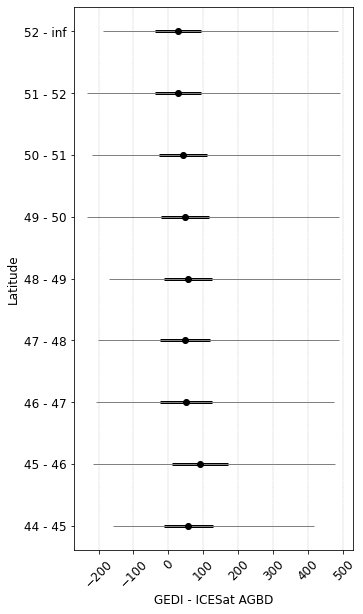

In [19]:
import matplotlib.pyplot as plt

# Calculate quartiles
q1 = mean - std
q3 = mean + std

bins = [44,45,46,47,48,49,50,51,52]

print(len(bins))
print(len(mean))

# Create boxplot
plt.figure(figsize = (5,10))
# plt.boxplot(mean)
# create stacked errorbars:
plt.errorbar(mean, bins, xerr = std, fmt='ok', lw=3)
plt.errorbar(mean, bins, xerr = [mean - min, max - mean],
             fmt='.k', ecolor='gray', lw=1)
xticks = ["" for i in range(len(bins))]
for i in range(len(bins)-1):
    xticks[i] = (str(bins[i]) + " - "+ str(bins[i+1]) )
xticks[-1] = ("52 - inf" )
plt.yticks(bins, labels=xticks, size = 12)
plt.ylabel('Latitude', size = 12)
plt.xlabel('GEDI - ICESat AGBD', size = 12)
plt.xticks(rotation = 45, size = 12)
plt.grid(True, axis='x', linestyle='--', linewidth=0.4)
plt.show()


